### 1) Loading dataset

* importing necessary libraries to read dataset

In [12]:
import os
import ast
import numpy as np
import pandas as pd
from PIL import Image

* setting paths for dataset files

In [9]:
# setting paths for train and test data
train_dir = "train"
train_annot_path = os.path.join(train_dir, "annotation.txt")

test_dir = "test"
test_annot_path = os.path.join(test_dir, "annotation.txt")

# setting paths for classes.txt
classes_txt_path = "classes.txt"

* getting class labels from annotation and class files

In [10]:
# getting class labels from "classes.txt"
with open(classes_txt_path) as file:
    class_map_s2i = {line.rstrip():i for i, line in enumerate(file.readlines()) if line.rstrip()}
class_map_i2s = {v:k for k,v in class_map_s2i.items()}

# getting labels for train data from "train/annotation.txt"
with open(train_annot_path) as file:
    train_annots = [line.rstrip().split() for line in file.readlines()]
train_img_path = [os.path.join(train_dir, train_annot[0][:4], train_annot[0]+".jpg") for train_annot in train_annots]
train_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in train_annot[1:]])) for train_annot in train_annots]
train_str_lbl = [class_map_i2s[x] for x in train_int_lbl]

# getting labels for test data from "test/annotation.txt"
with open(test_annot_path) as file:
    test_annots = [line.rstrip().split() for line in file.readlines()]
test_img_path = [os.path.join(test_dir, test_annot[0][:4], test_annot[0]+".jpg") for test_annot in test_annots]
test_int_lbl = [np.argmax(np.array([int(ast.literal_eval(x)) for x in test_annot[1:]])) for test_annot in test_annots]
test_str_lbl = [class_map_i2s[x] for x in test_int_lbl]

* creating dataframes for train and test set

In [13]:
# creating dataframes for train and test data
train_df = pd.DataFrame({"img_path":train_img_path, "int_label":train_int_lbl, "str_label":train_str_lbl})
test_df = pd.DataFrame({"img_path":test_img_path, "int_label":test_int_lbl, "str_label":test_str_lbl})

# displaying dataframes
print("\n\nTRAIN DF")
display(train_df)
print(train_df.str_label.value_counts(dropna=False))

print("\n\n\nTEST DF")
display(test_df)
print(test_df.str_label.value_counts())



TRAIN DF


,img_path,int_label,str_label
0,train\0000\000000.jpg,4,tree
1,train\0000\000001.jpg,1,car
2,train\0000\000002.jpg,2,building
3,train\0000\000003.jpg,1,car
4,train\0000\000004.jpg,1,car
...,...,...,...
39995,train\0399\039995.jpg,0,person
39996,train\0399\039996.jpg,0,person
39997,train\0399\039997.jpg,0,person
39998,train\0399\039998.jpg,0,person


str_label
person       24024
window        4153
car           3994
building      2233
tree          2073
sign           968
door           881
chair          432
bookshelf      404
keyboard       350
head           268
table          220
Name: count, dtype: int64



TEST DF


,img_path,int_label,str_label
0,test\0000\000000.jpg,1,car
1,test\0000\000001.jpg,0,person
2,test\0000\000002.jpg,1,car
3,test\0000\000003.jpg,1,car
4,test\0000\000004.jpg,0,person
...,...,...,...
9995,test\0099\009995.jpg,0,person
9996,test\0099\009996.jpg,1,car
9997,test\0099\009997.jpg,2,building
9998,test\0099\009998.jpg,0,person


str_label
person       5937
window       1043
car          1019
building      588
tree          543
sign          258
door          191
chair         107
bookshelf     103
keyboard       84
head           65
table          62
Name: count, dtype: int64


* visualizing the images in the dataset

Image Class: tree
Image Height: 256
Image Width: 256


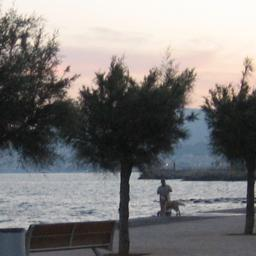

In [19]:
# displaying first image from train data
print(f"Image Class: {train_df.str_label[0]}")
print(f"Image Height: {Image.open(train_df.img_path[0]).height}")
print(f"Image Width: {Image.open(train_df.img_path[0]).width}")
Image.open(train_df.img_path[0])

Image Class: car
Image Height: 256
Image Width: 256


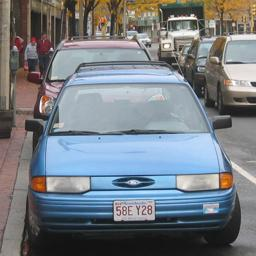

In [20]:
# displaying first image from test data
print(f"Image Class: {test_df.str_label[0]}")
print(f"Image Height: {Image.open(test_df.img_path[0]).height}")
print(f"Image Width: {Image.open(test_df.img_path[0]).width}")
Image.open(test_df.img_path[0])

<Axes: xlabel='str_label'>

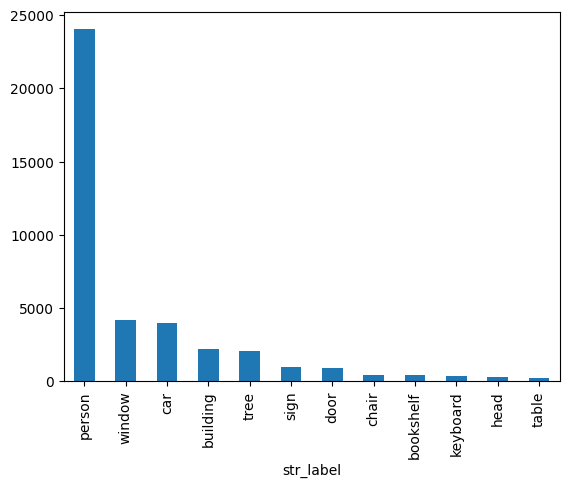

In [17]:
# plotting class distribution for train data
train_df['str_label'].value_counts().plot(kind='bar')

### 2) Creating Dataloaders

* importing necessary libraries for dataloader

In [21]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms

* defining class to load custom dataset

In [22]:
class CustomDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, idx):
        img_path = self.dataframe.iloc[idx, 0]
        img = Image.open(img_path)
        label = int(self.dataframe.iloc[idx, 1])

        if self.transform:
            img = self.transform(img)

        return img, label


* defining transforms

In [23]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # Resize images to the desired size
    transforms.ToTensor(),           # Convert images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], 
                        std=[0.229, 0.224, 0.225])  # Normalized using ImageNet stats
])


* instantiating custom dataset for train and test data

In [25]:
train_dataset = CustomDataset(train_df, transform=transform)
test_dataset = CustomDataset(test_df, transform=transform)

* creating dataloaders for train and test data

In [26]:
batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [27]:
# Find the number of samples/batches per dataloader
print(f"Number of batches of size {batch_size} in training data: {len(train_loader)}")
print(f"Number of batches of size {batch_size} in testing data: {len(test_loader)}")
print(f"Number of classes: {len(class_map_s2i)}, class names: {class_map_s2i}")

Number of batches of size 32 in training data: 1250
Number of batches of size 32 in testing data: 313
Number of classes: 12, class names: {'person': 0, 'car': 1, 'building': 2, 'window': 3, 'tree': 4, 'sign': 5, 'door': 6, 'bookshelf': 7, 'chair': 8, 'table': 9, 'keyboard': 10, 'head': 11}


### 3) Defining Model